# MLP Results (Paper)

Train an MLP regressor or classifier to learn the AoA estimation error.

## Config parameters

In [1]:
experiment = 1
experiment_set_name = 'xgb_paper'

In [3]:
## Data analysis parameters

# Set to true to discard any data with rotation values >= 360
restrict_single_rot = False
# Compute rotation angles modulo 360
wrap_to_single_rot = True

# Number of bins for binned analysis
nbins = 50

# Dataset to use if plot is restricted to single dataset
target = '300cm'
#target = '2m'

## Data input parameters

# How many measurements were collected at each angle
twr_per_angle = 5

# Input files
input_data = ('cache_config_rotation.csv', 'processed_data_cache_rotation.h5')

# Minimal cache version supported by this analysis script
cache_min_version = 3  # complex sts values required

# True: Load separate datasets into `dataframes` dictionary and combined dataset into `df_full`
# False: Load only combined dataset into `df_full`
get_dataframes = False

# Set to None to get distance from measurement title, otherwise the value given here will be set as distance
fixed_distance = None

# configure used ml libs
USE_XGB = True
USE_TF = False

## Library imports

In [4]:
# version of setup copied from setup notebook
setup_version = 16

In [6]:
# general python imports
import os
import csv
import math
import random
import warnings
import collections
from fractions import Fraction
from collections import OrderedDict

# data processing
import numpy as np
from numpy.polynomial import Polynomial

import pandas as pd

import scipy

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
#import matplotlib.cm as cm => available as plt.cm
from matplotlib import widgets as plt_widgets
from matplotlib.projections import get_projection_class
import matplotlib.patches as patches

# learning
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score
from sklearn.neural_network import MLPClassifier, MLPRegressor

if USE_XGB:
    import xgboost as xgb

if USE_TF:
    import tensorflow as tf
    from tensorflow import keras
    import keras_tuner

# helper functions
from tqdm.notebook import trange, tqdm  # progress bars
import joblib  # persisting sklearn models

## Matplotlib configuration

In [7]:
# better backend for non-interactive plots
%matplotlib inline

# backend for interactive plots
#%matplotlib widget

plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 72
plt.rcParams["savefig.dpi"] = 120
plt.rcParams['axes.linewidth'] = 2  # thicker borders
plt.rcParams.update({'font.size': 12})  # uniform font size
plt.rcParams['svg.fonttype'] = 'none'  # make text available in svg

## Constants and general configration

In [8]:
## Physics and DW3000 properties

# Speed of light (m/s)
c = 299792458

# Units of the TDOA measurement
tdoa_units = 1/(128*499.2*1e6)
tdoa_ns = 1e-9/tdoa_units

In [9]:
## Parameters for AoA estimation

# Center frequency channel 5 (Hz)
freq = 6489.6*1e6

# Wavelength channel 5 (m)
l = c/freq

# Distance between antennas
#d = 0.023
d = 0.0231 # if we have 0.023 here l/(2*d) > 1 which makes arcsin impossible

## Data Input

Run "parse and cache" script to generate a HDF5 cache file. Since the parsing of text files takes so long this script only works with the cached data. If new data fields are required change the cache creation and rebuild the cache file.

The cache config csv file is read and compared to the values in the cache to make sure the correct data is read.

HDF locking is disable to allow reading here while the chaching script is still running. **Make sure the file is fully written before reading it here.**

In [10]:
def load_dataframes(config_file, cache_file, verbose=True):
    with open(config_file, newline='') as f:
        reader = csv.reader(f, delimiter=';')
        files = list(reader)[1:]  # skip header

    log_files = OrderedDict()
    for entry in files:
        if not entry:
            continue
        # entry: (title, filename, description)
        log_files[entry[0]] = (entry[1], entry[2])

    print('Read configuration:', log_files.keys())
    print()

    dataframes = OrderedDict()

    # Do not lock HDF file to allow reading in another process
    os.environ['HDF5_USE_FILE_LOCKING'] = '0'

    datapoints = 0
    with pd.HDFStore(cache_file, mode='r') as store:
        for title, (filename, description) in log_files.items():
            info_df = store.get('cache_'+title+'/info')
            df = store.get('cache_'+title+'/df')
            if (title == info_df.title[0]
                and filename == info_df.file_name[0]):
                print(title, '=>', info_df.description[0])
            else:
                print(title, '=>', 'ERROR stored data does not match configuration')
            # get cache version, it is assumed to be the same for all dataframes in the file
            try:
                cache_version = info_df.version[0]
            except AttributeError:
                cache_version = 2
            df.info(memory_usage='deep')
            print()
            datapoints += len(df)
            dataframes[title] = df

    print(f'Read {datapoints} datapoints from {len(log_files)} experiments.')
    return cache_version, dataframes

## Data Preprocessing

In [11]:
def df_restrict_to_one_rotation(dataframes):
    '''Restrict data to one single rotation (rotation values 0 to 359)'''
    for title in dataframes:
        df = dataframes[title]
        # create a copy of the dataframes to avoid annoying assignment/copy warnings later
        dataframes[title] = df[(0 <= df.rotation) & (df.rotation < 360)].copy()

In [12]:
def df_wrap_to_one_rotation(dataframes):
    '''Wrap data to one single rotation (rotation values 0 to 359, i.e. modulo 360)'''
    for title in dataframes:
        df = dataframes[title]
        # create a copy of the dataframes to avoid annoying assignment/copy warnings later
        df.rotation = df.rotation % 360.
        dataframes[title] = df.copy()

In [13]:
def df_add_unwrapped_pdoa(dataframes):
    '''Unwrap PDoA values so they don't overflow at +/- pi anymore.

    Note: this needs access to the original/true rotation information, therefore
          it can't be computed on the device!

    Column added:
    - pdoa_fixed: "Unwrapped" PDoA values
    '''
    for df in dataframes.values():
        df['pdoa_fixed'] = df.pdoa
        df.loc[(df.pdoa > 1)  & (45 < df.rotation)  & (df.rotation < 155), ('pdoa_fixed', '')] -= 2*math.pi
        df.loc[(df.pdoa < -1) & (200 < df.rotation) & (df.rotation < 361), ('pdoa_fixed', '')] += 2*math.pi

In [14]:
def get_bins(nbins, *, borders=False, centers=False, bins=False):
    if sum([borders, centers, bins]) != 1:
        raise ValueError('Exactly one of bins, borders, centers has to be True')

    bin_borders = np.linspace(-1.5*np.pi, 1.5*np.pi, nbins)
    if borders:
        return bin_borders

    bin_centers = (bin_borders[:-1] + bin_borders[1:])/2
    if centers:
        return bin_centers

    return np.array(list(zip(bin_borders[:-1], bin_borders[1:])))


def df_add_pdoa_bins(dataframes, nbins):
    '''Put every measurement into a bin based on the PDoA or unwrapped PDoA value.

    The bins are evenly spaced over (-1.5 pi, 1.5 pi), i.e. the potential unwrapped
    PDoA range. The Bins for both original and unwrapped PDoA values are identical.

    Note: needs to be run after `df_add_unwrapped_pdoa` to get the pdoa_fixed column.

    Columns added:
    - pdoa_bins: Bin number of the (original) PDoA value of the sample
    - pdoa_fixed_bins: Bin number of the unwrapped PDoA value of the sample

    :param nbins: Number of bins to create
    '''
    bin_borders = get_bins(nbins, borders=True)

    for df in dataframes.values():
        df['pdoa_bins'] = np.digitize(df.pdoa, bin_borders)
        df['pdoa_fixed_bins'] = np.digitize(df.pdoa_fixed, bin_borders)

In [15]:
def df_add_aoa_estimate(dataframes):
    '''Compute angle of arrival (AoA) estimate "theta"

    Column added:
    - theta: Computed angle of arrival.
    '''
    for df in dataframes.values():
        df['theta'] = np.arcsin(df.pdoa*l/(2*math.pi*d))

In [16]:
def df_add_front_back(dataframes):
    '''Add column showing if signals originated at the front or back of receiver.

    Columns added:
    - fb: Categorical with 'front' or 'back' as options
    - rotation_fb: Rotation in (-90, 90) with 0 at original 0 for the front and 0 at original 180 for the back

    Note: +/-90 deg (90 an 270) is excluded from both (fb = NaN)!
    '''
    for df in dataframes.values():
        df['rotation_fb'] = df.rotation
        # Original rotations of 90 and 270 degrees are not included as front or back
        df.loc[df.rotation == 90, 'rotation_fb'] = np.nan
        df.loc[df.rotation == 270, 'rotation_fb'] = np.nan

        # "back" side of receiver
        df.loc[(90 < df.rotation) & (df.rotation < 270), 'fb'] = 'back'
        ## move rotation values 90 < r < 270 to -90 < r < 90
        ## this also moves 270 <= r < 360 to 90 <= r < 180
        #df.loc[df.rotation_fb > 90, ('rotation_fb', '')] -= 180

        # "front" side of receiver
        df.loc[(df.rotation < 90) | (270 < df.rotation), 'fb'] = 'front'
        ## move rotation values 270 < r < 360 to -90 < r < 0, but those values have
        ## already been moved to 90 < r < 180 in the previous step
        #df.loc[df.rotation_fb > 90, ('rotation_fb', '')] -= 180

        # move rotation values, s.t. front goes from -90 to 90, back is not changed
        df.loc[(df.fb == 'front') & (df.rotation > 270), ('rotation_fb', '')] -= 360

        cat_type = pd.CategoricalDtype(categories=['front', 'back'], ordered=False)
        df['fb'] = df['fb'].astype(cat_type)

In [17]:
def add_cir_abs(dataframes):
    '''Add columns for CIR absolute values.

    Note: Only relevant for cache_version > 2, where there the complex CIR columns
          replaced the absolute value columns.

    Columns added:
    - cir_sts1_abs: Absolute value of STS1 CIR
    - cir_sta2_abs: Absolute value of STS2 CIR
    '''
    for title in dataframes.keys():
        df = dataframes[title]
        df_abs = df[['cir_sts1', 'cir_sts2']].abs()
        df_abs = df_abs.rename(columns={'cir_sts1': 'cir_sts1_abs', 'cir_sts2': 'cir_sts2_abs'}, level=0)
        dataframes[title] = pd.concat([df, df_abs], axis=1)

In [18]:
def preprocess(dataframes, version, restrict_single_rot=False, wrap_to_single_rot=False, nbins=None):
    '''Run all preprocessing functions.

    :param dataframes: dict of DataFrames to be modified in place
    :param restrict_single_rot: Pass True to apply df_restrict_to_one_rotation
    :param nbins: See df_add_pdoa_bins
    '''

    if restrict_single_rot:
        df_restrict_to_one_rotation(dataframes)

    if wrap_to_single_rot:
        df_wrap_to_one_rotation(dataframes)

    print('Max rotation value:', [df.rotation.max() for df in dataframes.values()])

    df_add_unwrapped_pdoa(dataframes)

    if nbins:
        df_add_pdoa_bins(dataframes, nbins)

    df_add_aoa_estimate(dataframes)
    df_add_front_back(dataframes)

    if version > 2:
        add_cir_abs(dataframes)

    print('AoA estimation statistics:')
    for title in dataframes:
        df = dataframes[title]
        print(f'- {title:5}: {np.rad2deg(np.min(df.theta)):.3f}, deg to',
              f'{np.rad2deg(np.max(df.theta)):.3f} deg')

In [19]:
def merge_dataframes(dataframes, fixed_distance=None):
    '''Merge dictionary of dataframes into one large dataframe.

    The title (key in the input dictionary) is used to compute the true distance
    and both are added as columns.

    Columns added:
    - title: Title of the original data (key in input dict)
    - distance_m: Distance in meters computed from the title.
    '''
    titles = []
    for (title, df) in dataframes.items():
        if fixed_distance is None:
            # convert title with ...m or ...cm into a number in m
            if title.endswith('cm'):
                distance = int(title[:-2])/100
            else:
                distance = int(title[:1])
        else:
            distance = fixed_distance
        titles.append((distance, title))
        df['title'] = title
        df['distance_m'] = distance

    # concatenate dataframes and make the title column ordered categorical data
    df_full = pd.concat(dataframes.values(), ignore_index=True)
    cat_type = pd.CategoricalDtype(categories=[t[1] for t in sorted(titles)], ordered=True)
    df_full['title'] = df_full['title'].astype(cat_type)
    df_full.info(memory_usage='deep')
    return df_full

In [20]:
#def load_and_prepare(cache_config, cache_file, restrict_single_rot=False, nbins=50):
def load_and_prepare(cache_config, cache_file, get_dataframes=False):
    '''Load, preprocess and merge dataframes.

    :param cache_config: Data cache configuration file.
    :param cache_file: Data cache file
    '''
    version, dataframes = load_dataframes(cache_config, cache_file)
    if version < cache_min_version:
        warnings.warn(f'Loading cache version {version} data, minimal required set to {cache_min_version}')

    preprocess(dataframes, version, restrict_single_rot, wrap_to_single_rot, nbins)  # parameters taken from global configuration!
    df_full = merge_dataframes(dataframes, fixed_distance)
    if get_dataframes:
        return dataframes, df_full
    else:
        return df_full

## Optional preprocessing functions

In [21]:
def split_complex_columns(df, columns, levels=3):
    '''Split complex columns `columns` into real and imaginary parts.'''
    df_split_cir = df[columns].agg([np.real, np.imag])
    df_split_cir.rename(columns={c: c + '_split' for c in columns}, inplace=True)

    if len(df.columns.levels) < levels:
        df = df.copy()
        # add multiindex level to dataframe to fit the new split real/image level
        df.columns = pd.DataFrame(data=1, index=df.columns.copy(), columns=['']).stack().index
    return pd.concat([df, df_split_cir], axis=1)

## Plot helper functions

In [22]:
def axis_pi_formatter(axis, divisor=4, frac=False, indexed_values=None):
    '''Format axis in steps of fractions of pi.

    :param axis: Axis to be formatted. Either Axes instance (e.g. plt.gca()) to format the
                 the yaxis or specific axis to be formatted (e.g. plt.gca().xaxis)
    :param divisor: Divisions of pi to get ticks (default 4)
    :param frac: Format as fraction instead fo float (default False)
    '''
    if isinstance(axis, plt.Axes):
        axis = axis.yaxis

    #get_val = lambda v: (v if indexed_values is None else indexed_values[v])
    def get_val(v):
        #print(v)
        return v

    def format_frac(val):
        f = Fraction(val).as_integer_ratio()
        if f[1] == 1:
            return f'${f[0]}$'
        else:
            return f'$\\frac{{{f[0]}}}{{{f[1]}}}$'

    if frac:
        axis.set_major_formatter(plt.FuncFormatter(
            lambda val, pos: f'{format_frac(get_val(val)/np.pi)}$\\pi$' if val !=0 else '0'
        ))
    else:
        axis.set_major_formatter(plt.FuncFormatter(
           lambda val, pos: '{:.3g}$\\pi$'.format(get_val(val)/np.pi) if val !=0 else '0'
        ))

    axis.set_major_locator(plt.MultipleLocator(base=np.pi/divisor))

In [23]:
# source: https://stackoverflow.com/a/49601444
import matplotlib.colors as mc
import colorsys

def adjust_lightness(color, amount=0.5):
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [24]:
from itertools import islice, cycle, chain

def makexticks(ax, step=90):
    #twr_per_angle = 5 => defined above as global parameter
    tick_count = int((ax.get_xlim()[1])//(step*twr_per_angle))+1
    xticks = [i*step*twr_per_angle for i in range(0, tick_count)]
    labels = list(islice(cycle(chain(range(0, 360, 90), range(360, 0, -90))), tick_count))
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)

## Persistency / Output

In [25]:
def get_output_folder(*sub):
    folder = os.path.join('output', experiment_set_name, f'{experiment_set_name}_{experiment:02}', *sub)
    os.makedirs(folder, exist_ok=True)
    return folder

In [26]:
def save_plot(name, group=''):
    '''Save a figure into a subfolder for the experiment.'''
    folder = get_output_folder(group)
    plt.savefig(os.path.join(folder, name + '.png'), bbox_inches='tight')
    plt.savefig(os.path.join(folder, name + '.svg'), bbox_inches='tight')

In [27]:
def save_model(model, name, txt=None):
    folder = get_output_folder('_models', name)
    if USE_TF and isinstance(model, keras.Model):
        model.save(os.path.join(folder, name))
        keras.utils.plot_model(model, os.path.join(folder, name + '.png'), show_shapes=True)
    else:
        joblib.dump(model, os.path.join(folder, name + '.pkl'))

    if txt:
        with open(os.path.join(folder, name + '.txt'), 'wt') as f:
            f.write(txt)

In [28]:
def load_model(name, model_type='sklearn'):
    folder = get_output_folder('_models', name)
    if model_type == 'sklearn':
        return joblib.load(os.path.join(folder, name + '.pkl'))
    else:
        raise ValueError('Not supported model type.')

In [29]:
logfile = os.path.join(get_output_folder(), 'ipython_log.log')
%logstart -o -t $logfile

Activating auto-logging. Current session state plus future input saved.
Filename       : output/xgb_paper/xgb_paper_01/ipython_log.log
Mode           : backup
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


## Load dataset

In [30]:
if get_dataframes:
    dataframes, df_full = load_and_prepare(*input_data, get_dataframes=True)
else:
    df_full = load_and_prepare(*input_data)

Read configuration: odict_keys(['50cm', '100cm', '150cm', '200cm', '250cm', '300cm', '350cm', '400cm', '450cm', '500cm', '550cm'])

50cm => Distance 50cm, one full turn, 5 samples per 1 degree rotation step, LOS
<class 'pandas.core.frame.DataFrame'>
Index: 1905 entries, 0 to 1904
Columns: 218 entries, ('timestamp', '') to ('cir_sts2', 99)
dtypes: complex128(210), float64(4), int64(4)
memory usage: 6.2 MB

100cm => Distance 100cm, one full turn, 5 samples per 1 degree rotation step, LOS
<class 'pandas.core.frame.DataFrame'>
Index: 1780 entries, 0 to 1779
Columns: 218 entries, ('timestamp', '') to ('cir_sts2', 99)
dtypes: complex128(210), float64(4), int64(4)
memory usage: 5.8 MB

150cm => Distance 150cm, one full turn, 5 samples per 1 degree rotation step, LOS
<class 'pandas.core.frame.DataFrame'>
Index: 1804 entries, 0 to 1803
Columns: 218 entries, ('timestamp', '') to ('cir_sts2', 99)
dtypes: complex128(210), float64(4), int64(4)
memory usage: 5.9 MB

200cm => Distance 200cm, one full

In [31]:
df_full

timestamp number rotation      pdoa tdoa  dist_mm rx_power_level  \
                                                                          
0       14.01324      2      0.0 -0.251465   -1  7131221     -58.566101   
1       14.20220      4      0.0 -0.291504    2  7131252     -55.118826   
2       14.39129      6      0.0 -0.406250    6  7131294     -58.566101   
3       14.58020      8      0.0 -0.316895   -7  7131123     -58.108526   
4       14.76918     10      0.0 -0.296387   -6  7131169     -58.108526   
...          ...    ...      ...       ...  ...      ...            ...   
19875  393.62131   3589      0.0 -0.076660    3  7132072     -73.118826   
19876  393.82034   3591      0.0 -0.132324    0  7132185     -75.694599   
19877  394.02096   3593      0.0 -0.173340   -5  7132095     -75.694599   
19878  394.22085   3595      0.0 -0.063965    3  7132225     -73.118826   
19879  394.48833   3597      1.0 -0.255371   -9  7132041     -76.108526   

      fp_power_level          cir_sts1                    ...  cir_sts2_abs  \
                                    -5                -4  ...            92   
0         -47.074083  10240.0+ 9472.0j   5888.0+10240.0j  ...   7247.664796   
1         -43.617284   6654.0+ 6143.0j   2558.0+ 6143.0j  ...  14965.278380   
2         -46.801459  11263.0+ 3838.0j   8191.0+  256.0j  ...   8737.289339   
3         -46.568244    767.0+ 4096.0j    510.0+ 4609.0j  ...  16433.923938   
4         -46.447449  11520.0+14848.0j  11520.0+ 3072.0j  ...  11920.376043   
...              ...               ...               ...  ...           ...   
19875     -62.111808   4352.0+ 1536.0j   8702.0+ 3841.0j  ...  13361.600091   
19876     -64.313718    257.0+  255.0j   4350.0+ 1535.0j  ...   4126.884055   
19877     -64.434145   2814.0+12543.0j   2048.0+18432.0j  ...  12000.064083   
19878     -61.256190  10753.0+17153.0j   6913.0+ 4865.0j  ...  10100.170543   
19879     -64.699736   6143.0+ 4094.0j   4863.0+ 4608.0j  ...   2996.403177   

                                                                             \
                 93            94            95            96            97   
0       7461.526184   8507.969264  13119.687877   2985.790683   7421.896590   
1      13473.482104  12394.207679  12194.309493  12293.332176  13066.035359   
2      21681.552712  25213.075973  11636.037814   5837.172261  11151.001614   
3      17220.460505   9659.548695  14427.138871   9276.247517   1949.637915   
4      13349.102329   6104.624231  12139.772691   9957.708973   5100.763864   
...             ...           ...           ...           ...           ...   
19875  17847.553586  21639.194070  11019.900544   7059.972025  10503.997144   
19876  16487.423722  21086.628299  16385.000000  14654.078613  15632.696153   
19877  16389.967816  12553.955432  13398.220964   2755.533524   6802.691379   
19878  12676.524445  18003.917796  14982.015886   9564.949346   6191.813951   
19879   5099.208272   5118.000098  11418.553411   8720.455149   4614.551007   

                                   title distance_m  
                 98            99                    
0      13843.375492  15670.527911   50cm        0.5  
1      19315.704699  20026.989789   50cm        0.5  
2       8037.575816  13215.651327   50cm        0.5  
3       9811.849163  25349.171190   50cm        0.5  
4      11859.184458   8195.499497   50cm        0.5  
...             ...           ...    ...        ...  
19875  18219.286622  18944.729742  550cm        5.5  
19876  11112.458099   2768.231385  550cm        5.5  
19877  14084.763008   4469.416629  550cm        5.5  
19878   7283.990390  16714.448989  550cm        5.5  
19879   6104.330676   8825.737193  550cm        5.5  

[19880 rows x 436 columns]

In [32]:
if get_dataframes:
    print(dataframes.keys())

--- End of setup from setup and data input script ---

# Data Analysis

### Input processing

In [33]:
df_full

timestamp number rotation      pdoa tdoa  dist_mm rx_power_level  \
                                                                          
0       14.01324      2      0.0 -0.251465   -1  7131221     -58.566101   
1       14.20220      4      0.0 -0.291504    2  7131252     -55.118826   
2       14.39129      6      0.0 -0.406250    6  7131294     -58.566101   
3       14.58020      8      0.0 -0.316895   -7  7131123     -58.108526   
4       14.76918     10      0.0 -0.296387   -6  7131169     -58.108526   
...          ...    ...      ...       ...  ...      ...            ...   
19875  393.62131   3589      0.0 -0.076660    3  7132072     -73.118826   
19876  393.82034   3591      0.0 -0.132324    0  7132185     -75.694599   
19877  394.02096   3593      0.0 -0.173340   -5  7132095     -75.694599   
19878  394.22085   3595      0.0 -0.063965    3  7132225     -73.118826   
19879  394.48833   3597      1.0 -0.255371   -9  7132041     -76.108526   

      fp_power_level          cir_sts1                    ...  cir_sts2_abs  \
                                    -5                -4  ...            92   
0         -47.074083  10240.0+ 9472.0j   5888.0+10240.0j  ...   7247.664796   
1         -43.617284   6654.0+ 6143.0j   2558.0+ 6143.0j  ...  14965.278380   
2         -46.801459  11263.0+ 3838.0j   8191.0+  256.0j  ...   8737.289339   
3         -46.568244    767.0+ 4096.0j    510.0+ 4609.0j  ...  16433.923938   
4         -46.447449  11520.0+14848.0j  11520.0+ 3072.0j  ...  11920.376043   
...              ...               ...               ...  ...           ...   
19875     -62.111808   4352.0+ 1536.0j   8702.0+ 3841.0j  ...  13361.600091   
19876     -64.313718    257.0+  255.0j   4350.0+ 1535.0j  ...   4126.884055   
19877     -64.434145   2814.0+12543.0j   2048.0+18432.0j  ...  12000.064083   
19878     -61.256190  10753.0+17153.0j   6913.0+ 4865.0j  ...  10100.170543   
19879     -64.699736   6143.0+ 4094.0j   4863.0+ 4608.0j  ...   2996.403177   

                                                                             \
                 93            94            95            96            97   
0       7461.526184   8507.969264  13119.687877   2985.790683   7421.896590   
1      13473.482104  12394.207679  12194.309493  12293.332176  13066.035359   
2      21681.552712  25213.075973  11636.037814   5837.172261  11151.001614   
3      17220.460505   9659.548695  14427.138871   9276.247517   1949.637915   
4      13349.102329   6104.624231  12139.772691   9957.708973   5100.763864   
...             ...           ...           ...           ...           ...   
19875  17847.553586  21639.194070  11019.900544   7059.972025  10503.997144   
19876  16487.423722  21086.628299  16385.000000  14654.078613  15632.696153   
19877  16389.967816  12553.955432  13398.220964   2755.533524   6802.691379   
19878  12676.524445  18003.917796  14982.015886   9564.949346   6191.813951   
19879   5099.208272   5118.000098  11418.553411   8720.455149   4614.551007   

                                   title distance_m  
                 98            99                    
0      13843.375492  15670.527911   50cm        0.5  
1      19315.704699  20026.989789   50cm        0.5  
2       8037.575816  13215.651327   50cm        0.5  
3       9811.849163  25349.171190   50cm        0.5  
4      11859.184458   8195.499497   50cm        0.5  
...             ...           ...    ...        ...  
19875  18219.286622  18944.729742  550cm        5.5  
19876  11112.458099   2768.231385  550cm        5.5  
19877  14084.763008   4469.416629  550cm        5.5  
19878   7283.990390  16714.448989  550cm        5.5  
19879   6104.330676   8825.737193  550cm        5.5  

[19880 rows x 436 columns]

In [34]:
df_full = split_complex_columns(df_full, ['cir_sts1', 'cir_sts2'])

/tmp/ipykernel_2324/843029871.py:3: FutureWarning: using <function real at 0x7ffb6aaf0b80> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df_split_cir = df[columns].agg([np.real, np.imag])
/tmp/ipykernel_2324/843029871.py:3: FutureWarning: using <function imag at 0x7ffb6aaf0cc0> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df_split_cir = df[columns].agg([np.real, np.imag])


In [35]:
rotation_full = -np.deg2rad(df_full.rotation)
rotation_full[rotation_full < -np.pi] += 2*np.pi  # let rotation values go from -pi to pi, not 0 to 2pi
df_full['rotation_rad'] = rotation_full

In [36]:
df_full.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19880 entries, 0 to 19879
Columns: 857 entries, ('timestamp', '', '') to ('rotation_rad', '', '')
dtypes: category(2), complex128(210), float64(640), int64(5)
memory usage: 161.6 MB


## I/O definition

### Potential input variables:
* PDoA
* TDoA
* CIR: cir_sts1_abs, cir_sts2_abs, etc.

### Potential target variables:
* Distance estimation error
* AoA estimation error

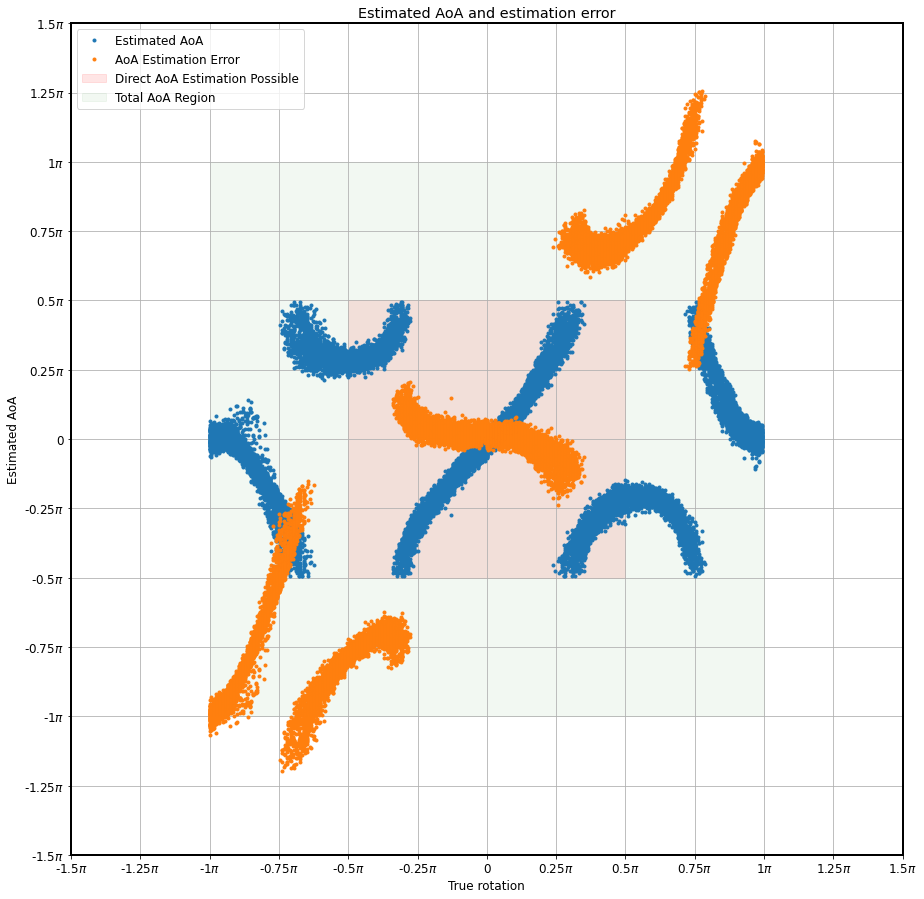

In [37]:
fig, ax = plt.subplots(figsize=(15, 15))

df = df_full

plt.plot(df.rotation_rad, df.theta, '.', label='Estimated AoA')

plt.plot(df.rotation_rad, df.rotation_rad-df.theta, '.', label='AoA Estimation Error')

#plt.vlines([-0.5*np.pi, 0.5*np.pi], -1.25*np.pi, 1.25*np.pi, color='red', linestyle='dotted')

rect = patches.Rectangle([-0.5*np.pi, -0.5*np.pi], np.pi, np.pi, edgecolor='red', facecolor='red', alpha=0.1, label='Direct AoA Estimation Possible')
ax.add_patch(rect)
rect = patches.Rectangle([-np.pi, -np.pi], 2*np.pi, 2*np.pi, edgecolor='green', facecolor='green', alpha=0.05, label='Total AoA Region')
ax.add_patch(rect)

plt.ylim(-1.5*np.pi, 1.5*np.pi)
plt.xlim(-1.5*np.pi, 1.5*np.pi)
ax.set_aspect(1)

axis_pi_formatter(ax.xaxis)
axis_pi_formatter(ax.yaxis)
plt.grid()
plt.legend()

plt.title('Estimated AoA and estimation error')
plt.xlabel('True rotation')
plt.ylabel('Estimated AoA')

save_plot('aoa_error')
plt.show()

### Select input and target variables

In [38]:
def filter_outliers(df):
    ok_idx = (df.tdoa > -tdoa_ns) & (df.tdoa < tdoa_ns) & (df.dist_mm > 1000)
    print(f'All: {len(df)}, keep: {len(df[ok_idx])}, discard: {len(df[~ok_idx])}')
    return df[ok_idx]

In [39]:
#data = df.loc[(90 <= df.rotation) & (df.rotation <= 270), ['pdoa', 'tdoa', 'cir_sts1_abs', 'rotation', 'theta']]
data = df_full.loc[:, ['pdoa', 'tdoa', 'rx_power_level', 'fp_power_level', 'cir_sts1_split', 'cir_sts2_split',
                       'cir_sts1_abs', 'cir_sts2_abs', 'dist_mm', 'rotation', 'theta', 'rotation_rad', 'distance_m']]

data['aoa_est_error'] = data.rotation_rad-data.theta
data['power'] = data.fp_power_level/data.rx_power_level

data = filter_outliers(data)

data

All: 19880, keep: 19508, discard: 372


pdoa tdoa rx_power_level fp_power_level cir_sts1_split           \
                                                               -5            
                                                             real     imag   
0     -0.251465   -1     -58.566101     -47.074083        10240.0   9472.0   
1     -0.291504    2     -55.118826     -43.617284         6654.0   6143.0   
2     -0.406250    6     -58.566101     -46.801459        11263.0   3838.0   
3     -0.316895   -7     -58.108526     -46.568244          767.0   4096.0   
4     -0.296387   -6     -58.108526     -46.447449        11520.0  14848.0   
...         ...  ...            ...            ...            ...      ...   
19875 -0.076660    3     -73.118826     -62.111808         4352.0   1536.0   
19876 -0.132324    0     -75.694599     -64.313718          257.0    255.0   
19877 -0.173340   -5     -75.694599     -64.434145         2814.0  12543.0   
19878 -0.063965    3     -73.118826     -61.256190        10753.0  17153.0   
19879 -0.255371   -9     -76.108526     -64.699736         6143.0   4094.0   

                                          ...  cir_sts2_abs                \
            -4               -3           ...            97            98   
          real     imag    real     imag  ...                               
0       5888.0  10240.0  1534.0   8447.0  ...   7421.896590  13843.375492   
1       2558.0   6143.0  8960.0   4864.0  ...  13066.035359  19315.704699   
2       8191.0    256.0  8192.0   3840.0  ...  11151.001614   8037.575816   
3        510.0   4609.0  1025.0   6401.0  ...   1949.637915   9811.849163   
4      11520.0   3072.0  2560.0   4862.0  ...   5100.763864  11859.184458   
...        ...      ...     ...      ...  ...           ...           ...   
19875   8702.0   3841.0  7425.0   3841.0  ...  10503.997144  18219.286622   
19876   4350.0   1535.0  5888.0   7680.0  ...  15632.696153  11112.458099   
19877   2048.0  18432.0  5886.0   7679.0  ...   6802.691379  14084.763008   
19878   6913.0   4865.0  5119.0   4350.0  ...   6191.813951   7283.990390   
19879   4863.0   4608.0  2048.0  17664.0  ...   4614.551007   6104.330676   

                     dist_mm rotation     theta rotation_rad distance_m  \
                 99                                                       
                                                                          
0      15670.527911  7131221      0.0 -0.080122    -0.000000        0.5   
1      20026.989789  7131252      0.0 -0.092914    -0.000000        0.5   
2      13215.651327  7131294      0.0 -0.129665    -0.000000        0.5   
3      25349.171190  7131123      0.0 -0.101033    -0.000000        0.5   
4       8195.499497  7131169      0.0 -0.094475    -0.000000        0.5   
...             ...      ...      ...       ...          ...        ...   
19875  18944.729742  7132072      0.0 -0.024402    -0.000000        5.5   
19876   2768.231385  7132185      0.0 -0.042129    -0.000000        5.5   
19877   4469.416629  7132095      0.0 -0.055199    -0.000000        5.5   
19878  16714.448989  7132225      0.0 -0.020360    -0.000000        5.5   
19879   8825.737193  7132041      1.0 -0.081370    -0.017453        5.5   

      aoa_est_error     power  
                               
                               
0          0.080122  0.803777  
1          0.092914  0.791332  
2          0.129665  0.799122  
3          0.101033  0.801401  
4          0.094475  0.799322  
...             ...       ...  
19875      0.024402  0.849464  
19876      0.042129  0.849647  
19877      0.055199  0.851238  
19878      0.020360  0.837762  
19879      0.063916  0.850098  

[19508 rows x 641 columns]

In [40]:
experiment

1

**PDoA, TDoA, complex CIR and distance estimate => AoA Error, distance**

(was experiment 5)

In [41]:
class CIRScaler2():
    def __init__(self, center_and_scale=[], scale_only=[], scale_min_max=[]):
        self.center_and_scale = center_and_scale
        self.scale_only = scale_only
        self.scale_min_max = scale_min_max

    def fit(self, data):
        self.mean_ = {}
        self.scale_ = {}
        self.offset_ = {}

        for col in self.center_and_scale:
            self.mean_[col] = data[col].values.mean()
            self.scale_[col] = data[col].values.std(ddof=1)
            self.offset_[col] = 0

        for col in self.scale_only:
            self.mean_[col] = 0  # only scale by maximum to preserve shape
            self.scale_[col] = data[col].values.max()
            self.offset_[col] = 0

        for col in self.scale_min_max:
            self.mean_[col] = 0
            data_min = data[col].min()
            self.scale_[col] = data[col].max()-data_min
            self.offset_[col] = data_min

        return self

    def transform(self, data, copy=True):
        if copy:
            data = data.copy()

        for col in self.center_and_scale + self.scale_only + self.scale_min_max:
            data[col] -= self.offset_[col]
            data[col] -= self.mean_[col]
            data[col] /= self.scale_[col]

        return data

    def info(self):
        s = [
            '* CIRScaler2:',
            'Inputs:'
            f'- center_and_scale: {self.center_and_scale}',
            f'- scale_only: {self.scale_only}',
            f'- scale_min_max: {self.scale_min_max}',
            'Fit:',
            f'- Mean {self.mean_}',
            f'- Scale {self.scale_}',
            f'- Offset {self.offset_}',
            '**'
        ]
        return '\n'.join(s)

In [42]:
class CIRScaler3():
    def __init__(self, center_and_scale=[], scale_only=[], scale_min_max=[]):
        self.center_and_scale = center_and_scale
        self.scale_only = scale_only
        self.scale_min_max = scale_min_max

    def fit(self, data):
        self.mean_ = {}
        self.scale_ = {}
        self.offset_ = {}

        for col in self.center_and_scale:
            self.mean_[col] = data[col].values.mean()
            self.scale_[col] = data[col].values.std(ddof=1)
            self.offset_[col] = 0

        for col in self.scale_only:
            self.mean_[col] = 0  # only scale by maximum to preserve shape
            self.scale_[col] = data[col].values.max()
            self.offset_[col] = 0

        for col in self.scale_min_max:
            self.mean_[col] = 0
            data_min = data[col].min()
            self.scale_[col] = data[col].max()-data_min
            self.offset_[col] = data_min

        return self

    def transform(self, data, copy=True):
        if copy:
            data = data.copy()

        for col in self.center_and_scale + self.scale_only + self.scale_min_max:
            data[col] -= self.offset_[col]
            data[col] -= self.mean_[col]
            data[col] /= self.scale_[col]

        return data

    def info(self):
        s = [
            '* CIRScaler2:',
            'Inputs:'
            f'- center_and_scale: {self.center_and_scale}',
            f'- scale_only: {self.scale_only}',
            f'- scale_min_max: {self.scale_min_max}',
            'Fit:',
            f'- Mean {self.mean_}',
            f'- Scale {self.scale_}',
            f'- Offset {self.offset_}',
            '**'
        ]
        return '\n'.join(s)

In [43]:
#X_cols = ['pdoa', 'tdoa', 'rx_power_level', 'fp_power_level', 'cir_sts1_split', 'cir_sts2_split', 'dist_mm']
#y_cols = ['aoa_est_error', 'distance_m']
#prep = CIRScaler2(['pdoa', 'tdoa'], ['cir_sts1_split', 'cir_sts2_split'], ['rx_power_level', 'fp_power_level', 'dist_mm'])

#X_cols = ['pdoa', 'tdoa', 'cir_sts1_split', 'cir_sts2_split', 'dist_mm']
#y_cols = ['aoa_est_error', 'distance_m']
#prep = CIRScaler2(['pdoa', 'tdoa'], ['cir_sts1_split', 'cir_sts2_split'], ['dist_mm'])

X_cols = ['pdoa', 'tdoa', 'cir_sts1_split', 'cir_sts2_split', 'dist_mm', 'power']
y_cols = ['aoa_est_error', 'distance_m']
prep = CIRScaler2(['pdoa', 'tdoa'], ['cir_sts1_split', 'cir_sts2_split', 'power'], ['dist_mm'])

In [44]:
data.dist_mm.values.min()

np.int64(7130846)

In [45]:
data.dist_mm.values.max()

np.int64(7132238)

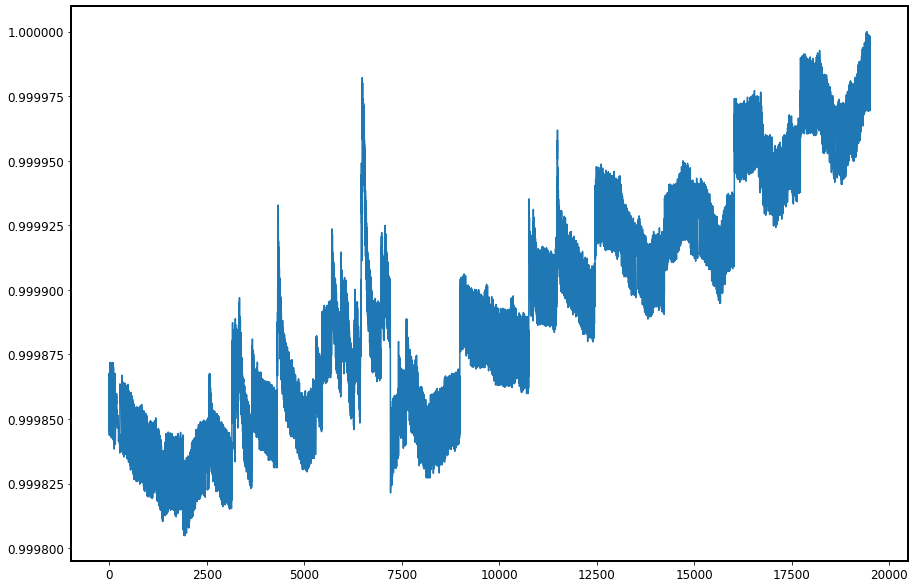

In [46]:
plt.plot((data.dist_mm.values/data.dist_mm.values.max()))

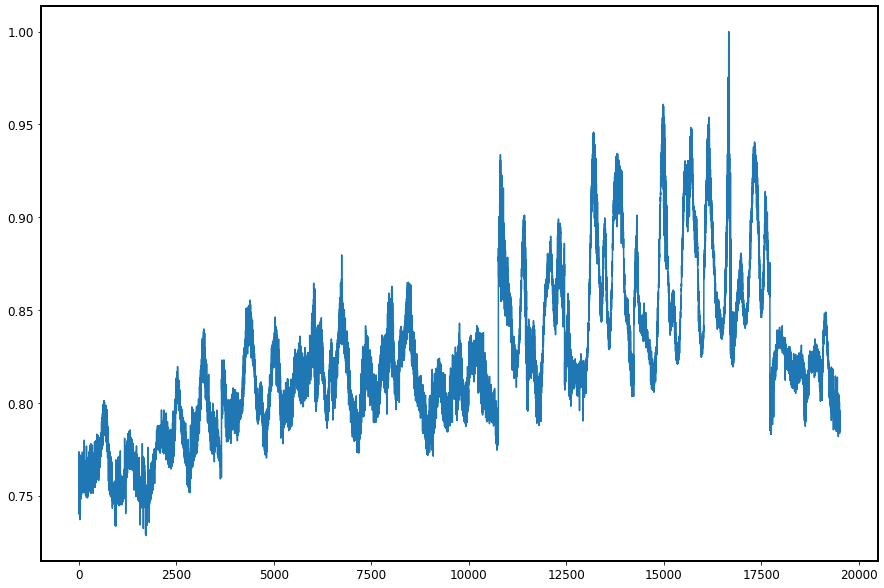

In [47]:
plt.plot((data.power.values/data.power.values.max()))

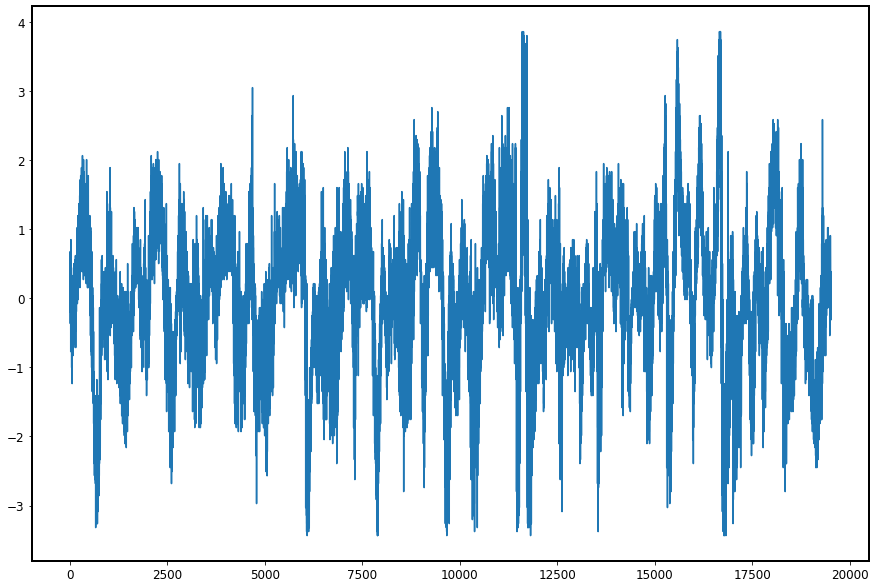

In [48]:
plt.plot((data.tdoa.values-data.tdoa.values.mean())/data.tdoa.values.std(ddof=1))

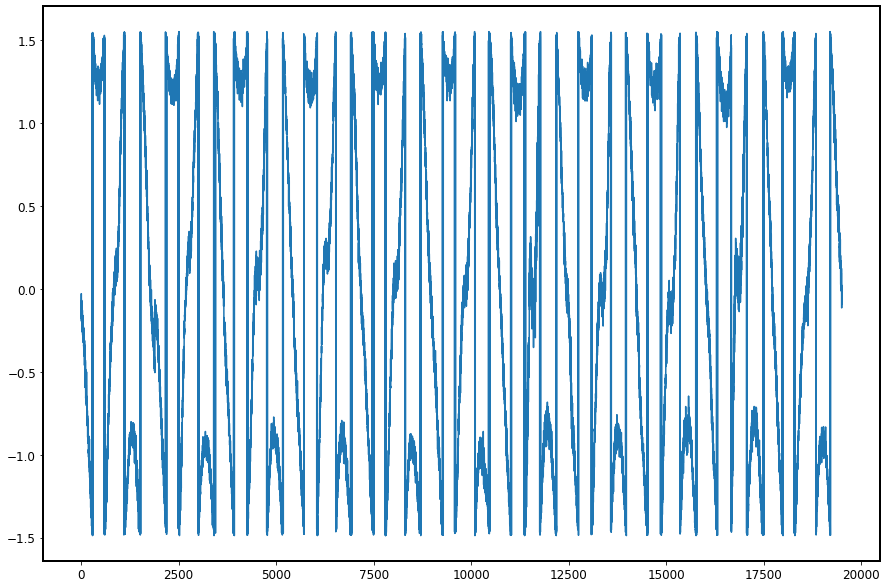

In [49]:
plt.plot((data.pdoa.values-data.pdoa.values.mean())/data.pdoa.values.std(ddof=1))

End of experiment definitions

In [50]:
X = data[X_cols]
y = data[y_cols]
# helper data for later analysis, not used in learning
meta = data[['rotation_rad', 'theta']]

In [51]:
# split dataset into training and test
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(X, y, meta, test_size=0.4, random_state=1)

print('Total samples:', len(X))
print('Training samples:', len(X_train))
print('Test samples', len(X_test))

Total samples: 19508
Training samples: 11704
Test samples 7804


In [52]:
print('X')
X_train.info()
print('\ny')
y_train.info()
print('\nmeta')
meta.info()

X
<class 'pandas.core.frame.DataFrame'>
Index: 11704 entries, 17347 to 236
Columns: 424 entries, ('pdoa', '', '') to ('power', '', '')
dtypes: float64(422), int64(2)
memory usage: 38.0 MB

y
<class 'pandas.core.frame.DataFrame'>
Index: 11704 entries, 17347 to 236
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   (aoa_est_error, , )  11704 non-null  float64
 1   (distance_m, , )     11704 non-null  float64
dtypes: float64(2)
memory usage: 274.3 KB

meta
<class 'pandas.core.frame.DataFrame'>
Index: 19508 entries, 0 to 19879
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (rotation_rad, , )  19508 non-null  float64
 1   (theta, , )         19508 non-null  float64
dtypes: float64(2)
memory usage: 457.2 KB


In [53]:
X_train

pdoa tdoa cir_sts1_split                                      \
                                 -5                -4                -3   
                               real     imag     real     imag     real   
17347  1.139160   10         7167.0   2560.0    766.0   4095.0   2814.0   
1335  -1.883301  -24         6912.0   4096.0   7424.0   1024.0    254.0   
6198  -1.578613  -47         6910.0   2305.0    511.0   2816.0   8192.0   
14505 -0.367676   -6         8448.0   3328.0   4608.0   5888.0   3840.0   
15429 -0.245605   20         8192.0    512.0   4864.0   2304.0   5632.0   
...         ...  ...            ...      ...      ...      ...      ...   
11079 -2.499023   -6         9984.0   9472.0  23552.0   5632.0  23808.0   
17648 -1.597168    0        16128.0  10752.0   9984.0  12288.0   5886.0   
5228   2.886230  -16        11520.0   7680.0   4608.0    254.0   5889.0   
12398 -3.044434  -10         7167.0   1278.0   7423.0    256.0   8704.0   
236   -2.530273   14         2046.0   4097.0   2049.0   2049.0   4863.0   

                                  ... cir_sts2_split                    \
                     -2           ...             96                97   
          imag     real     imag  ...           real     imag     real   
17347  15871.0   1792.0  13056.0  ...        15616.0  44544.0  16896.0   
1335    1281.0   4097.0   2815.0  ...         3838.0   1791.0    256.0   
6198   12544.0   7680.0  17664.0  ...         7167.0   5886.0   5887.0   
14505   6656.0   8192.0   8958.0  ...         1536.0    512.0  15616.0   
15429   5120.0   4864.0   5632.0  ...        19457.0  13823.0   6656.0   
...        ...      ...      ...  ...            ...      ...      ...   
11079   4094.0   9215.0   1022.0  ...         5375.0   1534.0    767.0   
17648   9215.0  10494.0   7679.0  ...         3326.0   8191.0  10240.0   
5228     511.0  11774.0   5887.0  ...         6400.0  12800.0   2304.0   
12398    256.0   2304.0    512.0  ...        34560.0  26368.0  33792.0   
236     2048.0  10496.0   2046.0  ...         1278.0   5375.0   5374.0   

                                                    dist_mm     power  
                     98                99                              
          imag     real     imag     real     imag                     
17347  18432.0   2302.0   4351.0  14590.0  16383.0  7131894  0.923532  
1335    5120.0   4352.0   1536.0   2816.0   1022.0  7131044  0.830486  
6198     256.0   8448.0   4094.0  13823.0   6142.0  7131357  0.871938  
14505   8960.0  18176.0  15104.0   4862.0  20991.0  7131786  0.921824  
15429  24320.0  18944.0   6656.0  15616.0  11518.0  7131703  0.904693  
...        ...      ...      ...      ...      ...      ...       ...  
11079   7934.0  10241.0  16897.0  15361.0  17409.0  7131562  0.905297  
17648    256.0  18432.0  11006.0   7167.0  21758.0  7131765  0.994080  
5228    6912.0   1024.0   6144.0   8446.0   3839.0  7131077  0.848934  
12398  14336.0  16640.0  11264.0  21760.0   9472.0  7131433  0.910180  
236     4351.0   2558.0    511.0   4096.0   3328.0  7131130  0.804746  

[11704 rows x 424 columns]

In [54]:
y_train

,aoa_est_error,distance_m
,,
,,
17347,2.194606,5.0
1335,2.265931,0.5
6198,-1.951946,2.0
14505,0.047480,4.5
15429,3.062764,4.5
...,...,...
11079,0.238976,3.5
17648,2.051702,5.0


In [55]:
meta_train

,rotation_rad,theta
,,
,,
17347,2.565634,0.371028
1335,1.623156,-0.642775
6198,-2.478368,-0.526422
14505,-0.069813,-0.117293
15429,2.984513,-0.078251
...,...,...
11079,-0.680678,-0.919654
17648,1.518436,-0.533266


## Preprocess data

In [56]:
# scale X data (column wise) to zero mean and unit variance

#scaler = preprocessing.StandardScaler().fit(X_train)
#scaler.mean_, scaler.scale_

scaler = prep.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Training Regressor

In [57]:
%%time

regr = xgb.XGBRegressor(random_state=1, n_estimators=100)
#XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
regr.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)])

#save_model(regr, 'mlp_regressor_defaults')
regr

[0]	validation_0-rmse:1.80593
[1]	validation_0-rmse:1.45587
[2]	validation_0-rmse:1.22727
[3]	validation_0-rmse:1.08683
[4]	validation_0-rmse:1.00030
[5]	validation_0-rmse:0.94312
[6]	validation_0-rmse:0.90279
[7]	validation_0-rmse:0.85950
[8]	validation_0-rmse:0.83837
[9]	validation_0-rmse:0.81928
[10]	validation_0-rmse:0.80411
[11]	validation_0-rmse:0.79031
[12]	validation_0-rmse:0.77643
[13]	validation_0-rmse:0.76706
[14]	validation_0-rmse:0.75751
[15]	validation_0-rmse:0.74128
[16]	validation_0-rmse:0.73286
[17]	validation_0-rmse:0.72753
[18]	validation_0-rmse:0.72268
[19]	validation_0-rmse:0.71879
[20]	validation_0-rmse:0.71055
[21]	validation_0-rmse:0.70582
[22]	validation_0-rmse:0.70174
[23]	validation_0-rmse:0.69806
[24]	validation_0-rmse:0.69411
[25]	validation_0-rmse:0.69100
[26]	validation_0-rmse:0.68525
[27]	validation_0-rmse:0.68397
[28]	validation_0-rmse:0.68367
[29]	validation_0-rmse:0.68060
[30]	validation_0-rmse:0.67991
[31]	validation_0-rmse:0.67706
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=1, ...)

In [58]:
regr.get_booster()

In [59]:
booster = regr.get_booster()

In [60]:
tree_df = booster.trees_to_dataframe()
tree_df

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,pdoa,1.074883,0-1,0-2,0-2,12564.349600,11704.0,NaN
1,0,1,0-1,pdoa,-0.811482,0-3,0-4,0-4,4556.250490,8544.0,NaN
2,0,2,0-2,tdoa,0.373375,0-5,0-6,0-6,661.017578,3160.0,NaN
3,0,3,0-3,tdoa,0.143926,0-7,0-8,0-8,348.849792,3932.0,NaN
4,0,4,0-4,pdoa,0.120593,0-9,0-10,0-10,1743.210940,4612.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
21883,199,110,199-110,Leaf,NaN,NaN,NaN,NaN,0.000699,44.0,NaN
21884,199,111,199-111,Leaf,NaN,NaN,NaN,NaN,0.000574,248.0,NaN
21885,199,112,199-112,Leaf,NaN,NaN,NaN,NaN,0.005441,181.0,NaN
21886,199,113,199-113,Leaf,NaN,NaN,NaN,NaN,0.000046,1638.0,NaN


In [61]:
tree_df[~tree_df.Split.isna()]

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,pdoa,1.074883,0-1,0-2,0-2,12564.349600,11704.0,NaN
1,0,1,0-1,pdoa,-0.811482,0-3,0-4,0-4,4556.250490,8544.0,NaN
2,0,2,0-2,tdoa,0.373375,0-5,0-6,0-6,661.017578,3160.0,NaN
3,0,3,0-3,tdoa,0.143926,0-7,0-8,0-8,348.849792,3932.0,NaN
4,0,4,0-4,pdoa,0.120593,0-9,0-10,0-10,1743.210940,4612.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
21828,199,55,199-55,pdoa,-0.847876,199-105,199-106,199-106,0.000184,5.0,NaN
21830,199,57,199-57,cir_sts2_split 4 imag,0.538575,199-107,199-108,199-108,0.022051,79.0,NaN
21831,199,58,199-58,cir_sts1_split 33 real,0.015470,199-109,199-110,199-110,0.025015,46.0,NaN
21832,199,59,199-59,cir_sts2_split 78 real,0.022604,199-111,199-112,199-112,0.027595,429.0,NaN


In [63]:
import m2cgen as m2c

In [65]:
#convert to c
regr.get_booster().dump_model("./xgb_model_output.txt")
with open('./xgb_model_time.c','w') as f:
    code = m2c.export_to_c(regr)
    f.write(code)

In [66]:
splits = code.count('if')
var_size = 4 # float
print(splits, var_size, splits * var_size)
print(f'-> {(splits * var_size)/1024:.0f}kb')

10844 4 43376
-> 42kb


In [67]:
feature_importances = pd.Series(regr.feature_importances_, index=X.columns).sort_values()
print('Total number of features:', len(feature_importances))
print('Features with importance <  0.01:', len(feature_importances[feature_importances < 0.01]))
print('Features with importance >= 0.01:', len(feature_importances[feature_importances >= 0.01]))

Total number of features: 424
Features with importance <  0.01: 416
Features with importance >= 0.01: 8


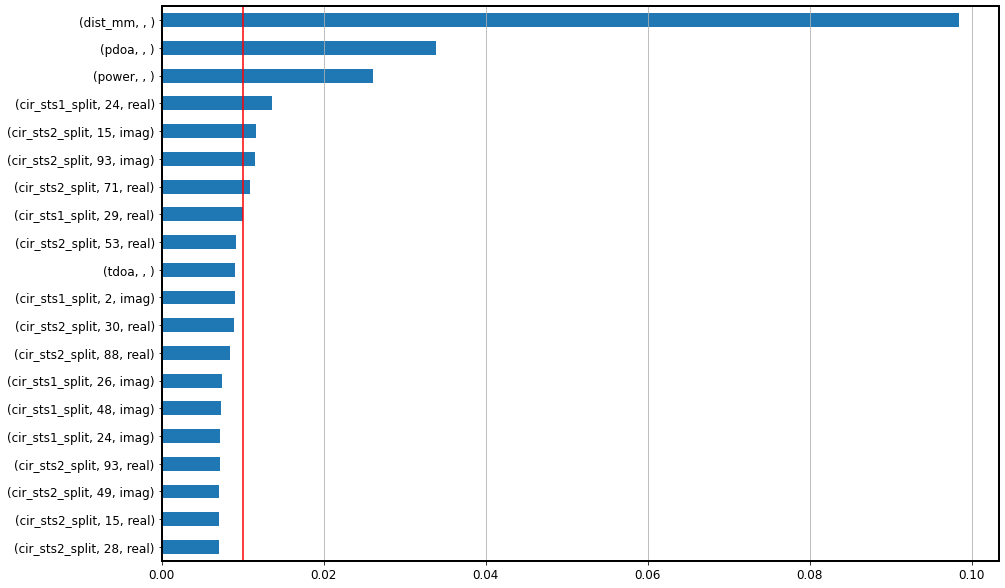

In [68]:
fig = plt.figure()
feature_importances.nlargest(20).plot(kind='barh').invert_yaxis()
#feature_importances[feature_importances >= 0.01].plot(kind='barh')
plt.axvline(0.01, color='red')
plt.grid(axis='x')

save_plot('xgb_feat_importance')
plt.show()

In [69]:
feature_importances.nlargest(10)

dist_mm                     0.098407
pdoa                        0.033897
power                       0.026104
cir_sts1_split  24  real    0.013558
cir_sts2_split  15  imag    0.011691
                93  imag    0.011575
                71  real    0.010918
cir_sts1_split  29  real    0.010021
cir_sts2_split  53  real    0.009113
tdoa                        0.009051
dtype: float32

In [70]:
regr.score(X_train_scaled, y_train)

0.9942357540130615

In [71]:
regr.score(X_test_scaled, y_test)

0.9016879796981812

### Prediction

In [72]:
y_pred_full = pd.DataFrame(regr.predict(scaler.transform(X)), index=y.index, columns=y.columns)
y_pred_train = pd.DataFrame(regr.predict(scaler.transform(X_train)), index=y_train.index, columns=y_train.columns)
y_pred_test = pd.DataFrame(regr.predict(scaler.transform(X_test)), index=y_test.index, columns=y_test.columns)

In [73]:
y_pred_full.describe()

,aoa_est_error,distance_m
,,
,,
count,19508.000000,19508.000000
mean,0.030166,2.977457
std,1.939238,1.579636
min,-4.088934,0.227907
25%,-1.961578,1.556574
50%,0.059743,2.971228
75%,1.951638,4.436845
max,4.538483,5.786646


In [74]:
mse = np.rad2deg(mean_squared_error(y.aoa_est_error, y_pred_full.aoa_est_error))
mae = np.rad2deg(mean_absolute_error(y.aoa_est_error, y_pred_full.aoa_est_error))
print(f'Full: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

mse = np.rad2deg(mean_squared_error(y_train.aoa_est_error, y_pred_train.aoa_est_error))
mae = np.rad2deg(mean_absolute_error(y_train.aoa_est_error, y_pred_train.aoa_est_error))
print(f'Train: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

mse = np.rad2deg(mean_squared_error(y_test.aoa_est_error, y_pred_test.aoa_est_error))
mae = np.rad2deg(mean_absolute_error(y_test.aoa_est_error, y_pred_test.aoa_est_error))
print(f'Test: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

Full: MSE 18.543 deg, MAE 19.314 deg
Train: MSE  2.504 deg, MAE  9.049 deg
Test: MSE 42.597 deg, MAE 34.709 deg


With power fraction:  
Full: MSE 21.524 deg, MAE 20.705 deg  
Train: MSE  3.291 deg, MAE 10.325 deg  
Test: MSE 45.385 deg, MAE 35.058 deg  

With power levels:  
Full: MSE 20.957 deg, MAE 20.617 deg  
Train: MSE  3.157 deg, MAE 10.180 deg  
Test: MSE 45.172 deg, MAE 35.276 deg  

In [75]:
mse = np.rad2deg(mean_squared_error(y, y_pred_full))
mae = np.rad2deg(mean_absolute_error(y, y_pred_full))
print(f'Full: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

mse = np.rad2deg(mean_squared_error(y_train, y_pred_train))
mae = np.rad2deg(mean_absolute_error(y_train, y_pred_train))
print(f'Train: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

mse = np.rad2deg(mean_squared_error(y_test, y_pred_test))
mae = np.rad2deg(mean_absolute_error(y_test, y_pred_test))
print(f'Test: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

Full: MSE 10.021 deg, MAE 12.274 deg
Train: MSE  1.338 deg, MAE  5.717 deg
Test: MSE 23.042 deg, MAE 22.107 deg


With power fraction:  
Full: MSE 11.709 deg, MAE 13.173 deg  
Train: MSE  1.748 deg, MAE  6.456 deg  
Test: MSE 24.811 deg, MAE 22.514 deg  

With power levels:  
Full: MSE 11.001 deg, MAE 12.433 deg  
Train: MSE  1.647 deg, MAE  6.139 deg  
Test: MSE 23.717 deg, MAE 21.264 deg  

In [76]:
# AoA est. is in [-0.5pi, 0.5pi] and AoA true is in [-pi, pi] reuslting in max AoA error pi+0.5pi = 1.5pi
outlier_pred = (y_pred_full.aoa_est_error < -1.5*np.pi) | (y_pred_full.aoa_est_error > 1.5*np.pi)
y_pred_full[outlier_pred]

,aoa_est_error,distance_m
,,
,,


In [77]:
X[outlier_pred]

Empty DataFrame
Columns: [(pdoa, , ), (tdoa, , ), (cir_sts1_split, -5, real), (cir_sts1_split, -5, imag), (cir_sts1_split, -4, real), (cir_sts1_split, -4, imag), (cir_sts1_split, -3, real), (cir_sts1_split, -3, imag), (cir_sts1_split, -2, real), (cir_sts1_split, -2, imag), (cir_sts1_split, -1, real), (cir_sts1_split, -1, imag), (cir_sts1_split, 0, real), (cir_sts1_split, 0, imag), (cir_sts1_split, 1, real), (cir_sts1_split, 1, imag), (cir_sts1_split, 2, real), (cir_sts1_split, 2, imag), (cir_sts1_split, 3, real), (cir_sts1_split, 3, imag), (cir_sts1_split, 4, real), (cir_sts1_split, 4, imag), (cir_sts1_split, 5, real), (cir_sts1_split, 5, imag), (cir_sts1_split, 6, real), (cir_sts1_split, 6, imag), (cir_sts1_split, 7, real), (cir_sts1_split, 7, imag), (cir_sts1_split, 8, real), (cir_sts1_split, 8, imag), (cir_sts1_split, 9, real), (cir_sts1_split, 9, imag), (cir_sts1_split, 10, real), (cir_sts1_split, 10, imag), (cir_sts1_split, 11, real), (cir_sts1_split, 11, imag), (cir_sts1_split, 12, real), (cir_sts1_split, 12, imag), (cir_sts1_split, 13, real), (cir_sts1_split, 13, imag), (cir_sts1_split, 14, real), (cir_sts1_split, 14, imag), (cir_sts1_split, 15, real), (cir_sts1_split, 15, imag), (cir_sts1_split, 16, real), (cir_sts1_split, 16, imag), (cir_sts1_split, 17, real), (cir_sts1_split, 17, imag), (cir_sts1_split, 18, real), (cir_sts1_split, 18, imag), (cir_sts1_split, 19, real), (cir_sts1_split, 19, imag), (cir_sts1_split, 20, real), (cir_sts1_split, 20, imag), (cir_sts1_split, 21, real), (cir_sts1_split, 21, imag), (cir_sts1_split, 22, real), (cir_sts1_split, 22, imag), (cir_sts1_split, 23, real), (cir_sts1_split, 23, imag), (cir_sts1_split, 24, real), (cir_sts1_split, 24, imag), (cir_sts1_split, 25, real), (cir_sts1_split, 25, imag), (cir_sts1_split, 26, real), (cir_sts1_split, 26, imag), (cir_sts1_split, 27, real), (cir_sts1_split, 27, imag), (cir_sts1_split, 28, real), (cir_sts1_split, 28, imag), (cir_sts1_split, 29, real), (cir_sts1_split, 29, imag), (cir_sts1_split, 30, real), (cir_sts1_split, 30, imag), (cir_sts1_split, 31, real), (cir_sts1_split, 31, imag), (cir_sts1_split, 32, real), (cir_sts1_split, 32, imag), (cir_sts1_split, 33, real), (cir_sts1_split, 33, imag), (cir_sts1_split, 34, real), (cir_sts1_split, 34, imag), (cir_sts1_split, 35, real), (cir_sts1_split, 35, imag), (cir_sts1_split, 36, real), (cir_sts1_split, 36, imag), (cir_sts1_split, 37, real), (cir_sts1_split, 37, imag), (cir_sts1_split, 38, real), (cir_sts1_split, 38, imag), (cir_sts1_split, 39, real), (cir_sts1_split, 39, imag), (cir_sts1_split, 40, real), (cir_sts1_split, 40, imag), (cir_sts1_split, 41, real), (cir_sts1_split, 41, imag), (cir_sts1_split, 42, real), (cir_sts1_split, 42, imag), (cir_sts1_split, 43, real), (cir_sts1_split, 43, imag), ...]
Index: []

[0 rows x 424 columns]

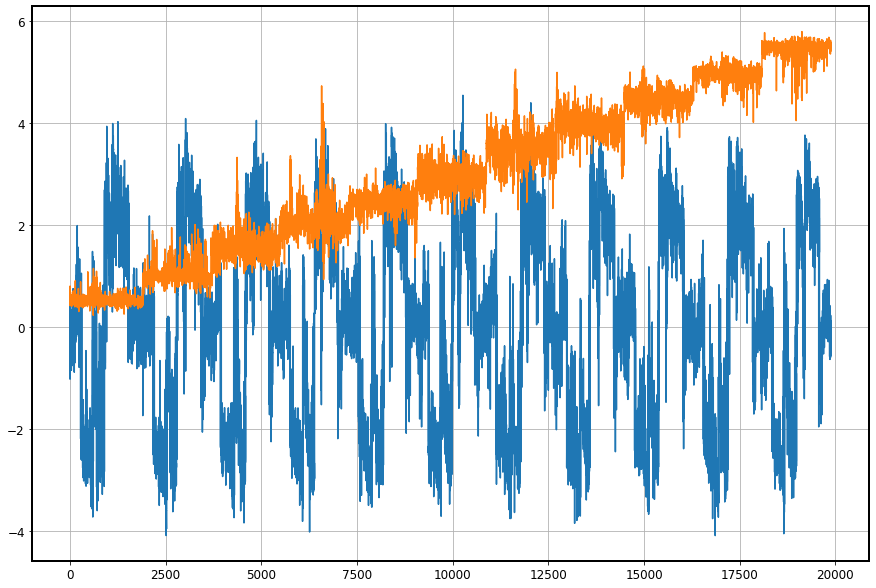

In [78]:
#y_pred = regr.predict(scaler.transform(X_test))
fig = plt.figure()
plt.plot(y_pred_full)
plt.grid()

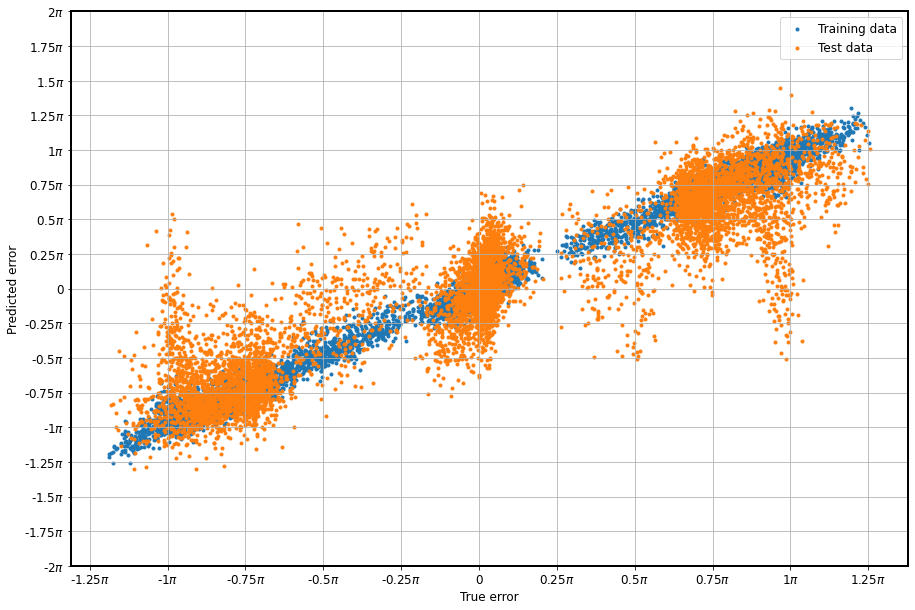

In [79]:
#figsize=(30, 20))
fig, ax = plt.subplots()
#plt.scatter(y_test, y_pred)
plt.scatter(y_train.aoa_est_error, y_pred_train.aoa_est_error, marker='.', label='Training data')
plt.scatter(y_test.aoa_est_error, y_pred_test.aoa_est_error, marker='.', label='Test data')
plt.ylim(-2*np.pi, 2*np.pi)
axis_pi_formatter(ax.yaxis)
axis_pi_formatter(ax.xaxis)
plt.xlabel('True error')
plt.ylabel('Predicted error')
plt.legend()
plt.grid()

save_plot('mlp_regr_predicted_error')
plt.show()

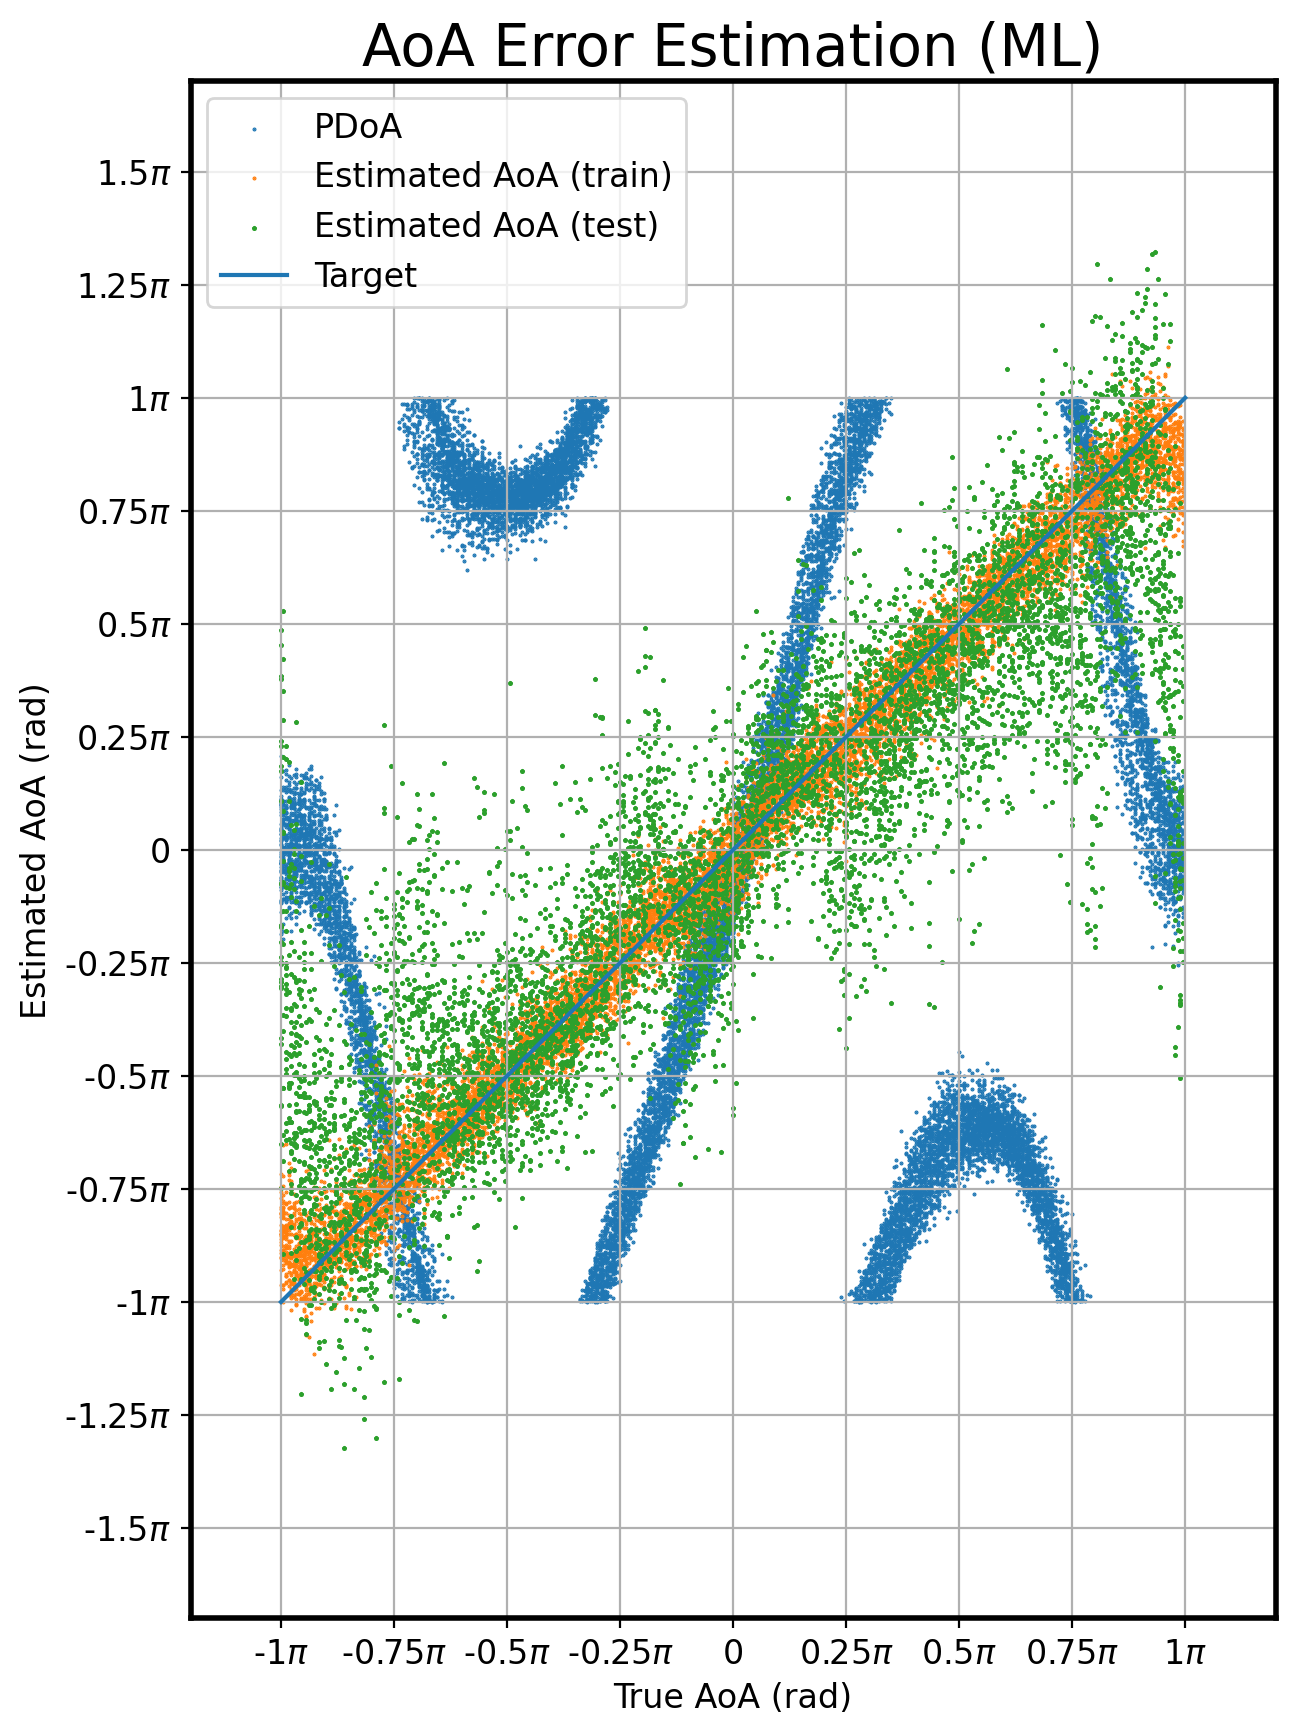

In [80]:
fig, ax = plt.subplots(figsize=(7, 10), dpi=200)

plt.scatter(data.rotation_rad, data.pdoa, marker='.', label='PDoA', s=0.8)
plt.scatter(meta_train.rotation_rad, meta_train.theta+y_pred_train.aoa_est_error, marker='.', s=0.8, label='Estimated AoA (train)')
plt.scatter(meta_test.rotation_rad, meta_test.theta+y_pred_test.aoa_est_error, marker='*', s=0.8, label='Estimated AoA (test)')

plt.plot([-np.pi, np.pi], [-np.pi, np.pi], label='Target')

axis_pi_formatter(ax.yaxis)
axis_pi_formatter(ax.xaxis)
plt.grid()
plt.legend()

plt.ylim(-1.7*np.pi, 1.7*np.pi)  # WARNING: this hides some extreme outliers
plt.xlim(-1.2*np.pi, 1.2*np.pi)
ax.set_aspect(1)

plt.title('AoA Error Estimation (ML)', fontsize='xx-large')
plt.xlabel('True AoA (rad)')
plt.ylabel('Estimated AoA (rad)')

save_plot('aoa_error_correction_regr (poster)')
plt.show()

In [81]:
np.rad2deg(1/4*np.pi)

np.float64(45.0)

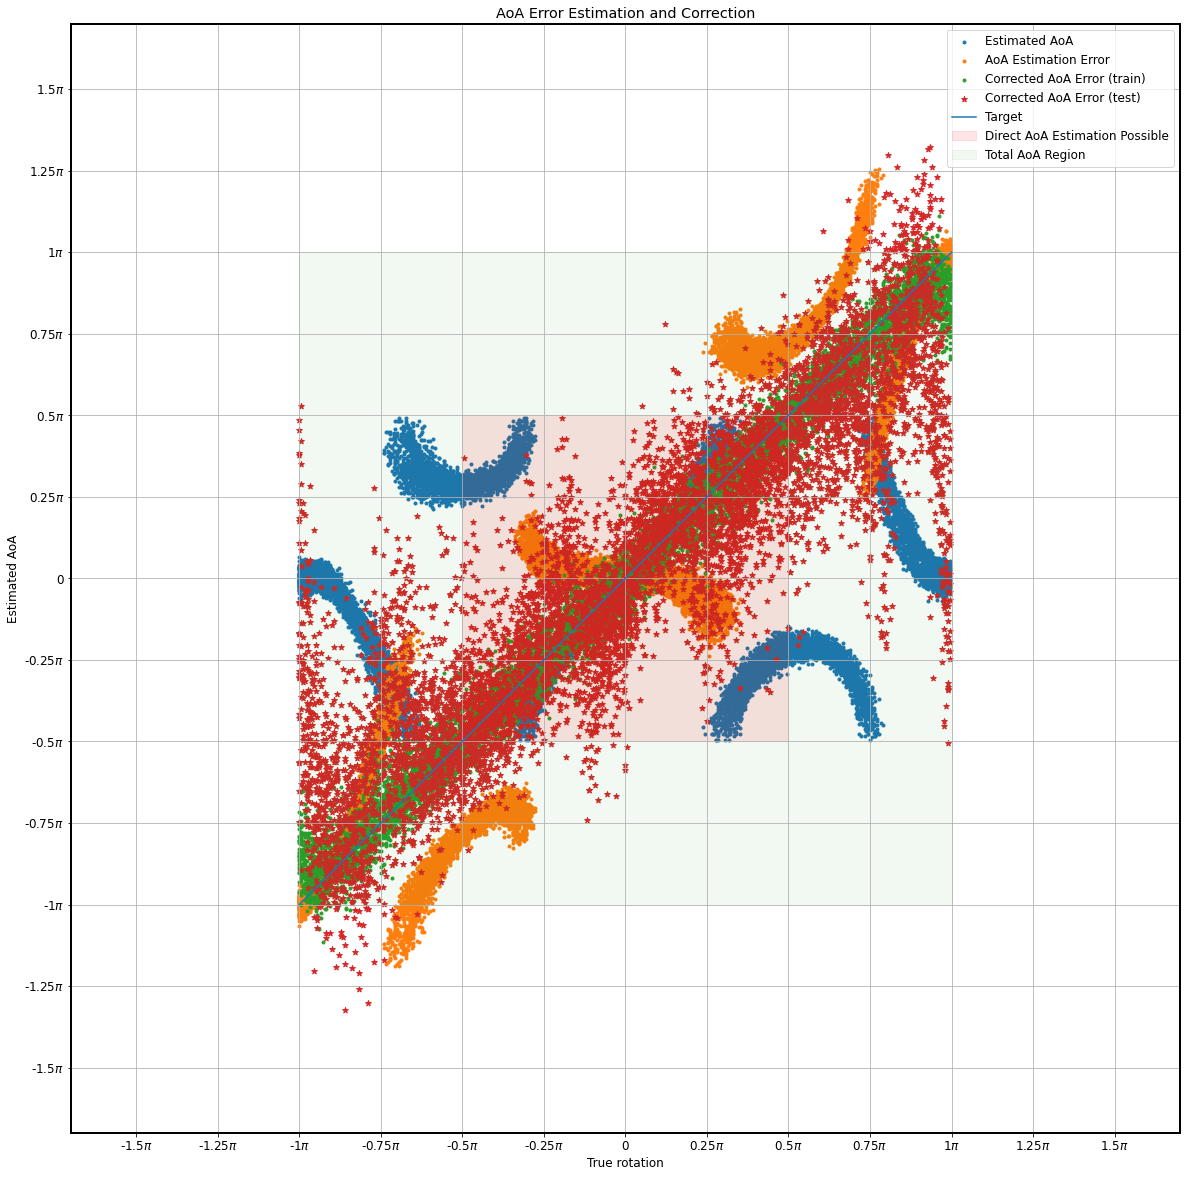

In [82]:
#fig, ax = plt.subplots(figsize=(15, 10))
fig, ax = plt.subplots(figsize=(30, 20))

plt.scatter(data.rotation_rad, data.theta, marker='.', label='Estimated AoA')

plt.scatter(data.rotation_rad, data.rotation_rad-data.theta, marker='.', label='AoA Estimation Error')

plt.scatter(meta_train.rotation_rad, meta_train.theta+y_pred_train.aoa_est_error, marker='.', label='Corrected AoA Error (train)')
plt.scatter(meta_test.rotation_rad, meta_test.theta+y_pred_test.aoa_est_error, marker='*', label='Corrected AoA Error (test)')

plt.plot([-np.pi, np.pi], [-np.pi, np.pi], label='Target')

rect = patches.Rectangle([-0.5*np.pi, -0.5*np.pi], np.pi, np.pi, edgecolor='red', facecolor='red', alpha=0.1, label='Direct AoA Estimation Possible')
ax.add_patch(rect)
rect = patches.Rectangle([-np.pi, -np.pi], 2*np.pi, 2*np.pi, edgecolor='green', facecolor='green', alpha=0.05, label='Total AoA Region')
ax.add_patch(rect)

axis_pi_formatter(ax.yaxis)
axis_pi_formatter(ax.xaxis)
plt.grid()
plt.legend()

plt.ylim(-1.7*np.pi, 1.7*np.pi)  # WARNING: this hides some extreme outliers
plt.xlim(-1.7*np.pi, 1.7*np.pi)
ax.set_aspect(1)

plt.title('AoA Error Estimation and Correction')
plt.xlabel('True rotation')
plt.ylabel('Estimated AoA')

save_plot('aoa_error_correction_regr')
plt.show()

In [83]:
print('*** Distance ***')

mse = mean_squared_error(y.distance_m, y_pred_full.distance_m)*100
mae = mean_absolute_error(y.distance_m, y_pred_full.distance_m)*100
print(f'Full: MSE {mse:6.3f} cm, MAE {mae:6.3f} cm')

mse = mean_squared_error(y_train.distance_m, y_pred_train.distance_m)*100
mae = mean_absolute_error(y_train.distance_m, y_pred_train.distance_m)*100
print(f'Train: MSE {mse:6.3f} cm, MAE {mae:6.3f} cm')

mse = mean_squared_error(y_test.distance_m, y_pred_test.distance_m)*100
mae = mean_absolute_error(y_test.distance_m, y_pred_test.distance_m)*100
print(f'Test: MSE {mse:6.3f} cm, MAE {mae:6.3f} cm')

*** Distance ***
Full: MSE  2.615 cm, MAE  9.134 cm
Train: MSE  0.300 cm, MAE  4.164 cm
Test: MSE  6.087 cm, MAE 16.589 cm


## Classification into 90 deg sectors

In [84]:
def get_classes(meta_df):
    classes = pd.DataFrame(index=meta_df.index, columns=['class'], dtype=int)
    # center: -45 to 45
    classes.loc[(meta_df.rotation_rad >= np.deg2rad(-45)) & (meta_df.rotation_rad < np.deg2rad(45)), 'class'] = 0
    # side 1: 45 to 135
    classes.loc[(meta_df.rotation_rad >= np.deg2rad(45)) & (meta_df.rotation_rad < np.deg2rad(135)), 'class'] = 1
    # back: 135 to 225 / -135
    classes.loc[(meta_df.rotation_rad >= np.deg2rad(135)) | (meta_df.rotation_rad < np.deg2rad(-135)), 'class'] = 2
    # side 225 to -45
    classes.loc[(meta_df.rotation_rad >= np.deg2rad(-135)) & (meta_df.rotation_rad < np.deg2rad(-45)), 'class'] = 3

    return classes.astype('int8')

In [85]:
y_cl = get_classes(meta)
y_train_cl = get_classes(meta_train)
y_test_cl = get_classes(meta_test)

In [86]:
y_train_cl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11704 entries, 17347 to 236
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   class   11704 non-null  int8 
dtypes: int8(1)
memory usage: 102.9 KB


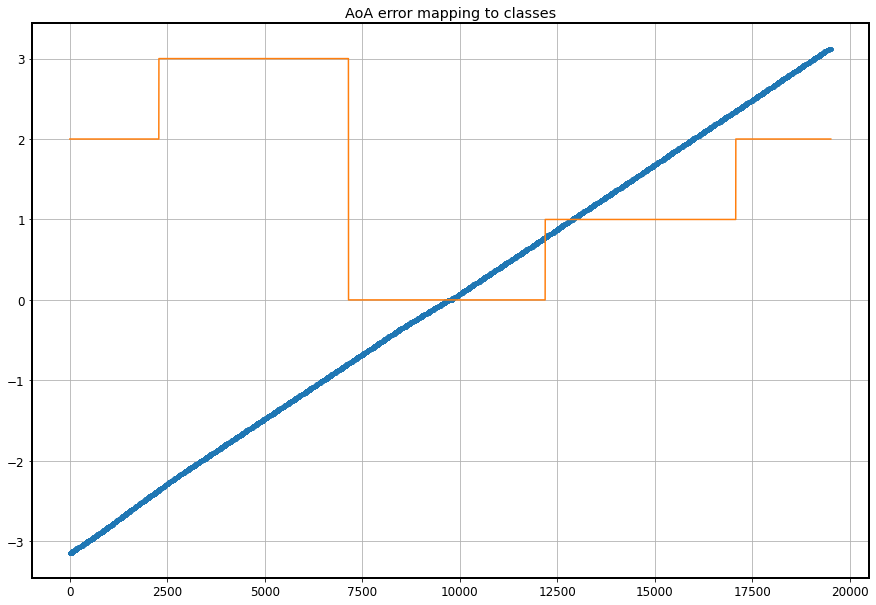

In [87]:
fig, ax = plt.subplots()
plt.plot(meta.loc[meta.rotation_rad.sort_values().index, 'rotation_rad'].reset_index(drop=True), '.')
plt.plot(y_cl.loc[meta.rotation_rad.sort_values().index].reset_index(drop=True))
plt.grid()
plt.title(f'AoA error mapping to classes')
save_plot('aoa_classes')
plt.show()

In [88]:
%%time

clf = xgb.XGBClassifier(random_state=1)
clf.fit(X_train_scaled, y_train_cl.values.ravel())
save_model(regr, 'mlp_classifier')
clf

CPU times: user 1min 39s, sys: 296 ms, total: 1min 39s
Wall time: 13.1 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [89]:
y_pred_train_cl = clf.predict(scaler.transform(X_train))
y_pred_test_cl = clf.predict(scaler.transform(X_test))

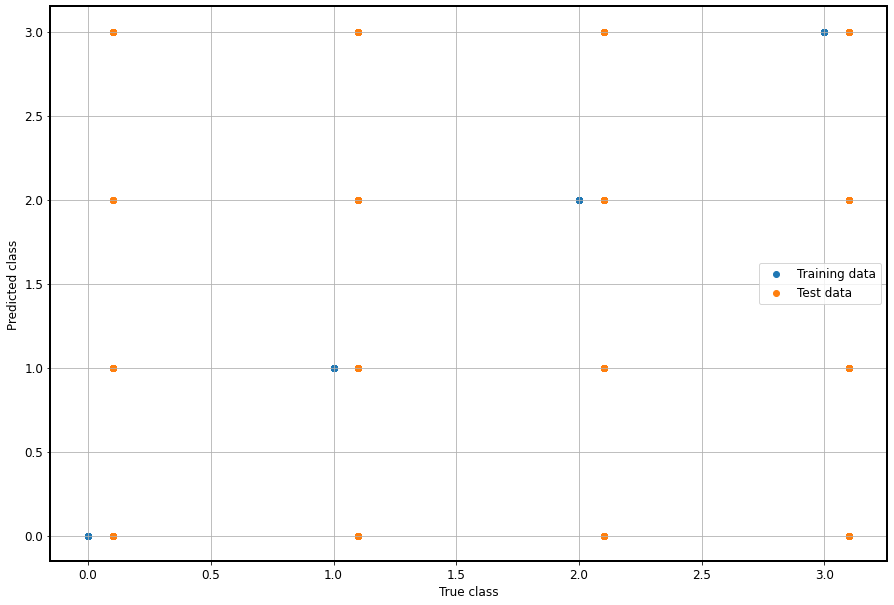

In [90]:
fig, ax = plt.subplots()#figsize=(30, 20))

plt.scatter(y_train_cl, y_pred_train_cl, label='Training data')
plt.scatter(y_test_cl+0.1, y_pred_test_cl, label='Test data')

plt.xlabel('True class')
plt.ylabel('Predicted class')
plt.legend()
plt.grid()

#save_plot('mlp_clf_aoa_predicted_error')
plt.show()

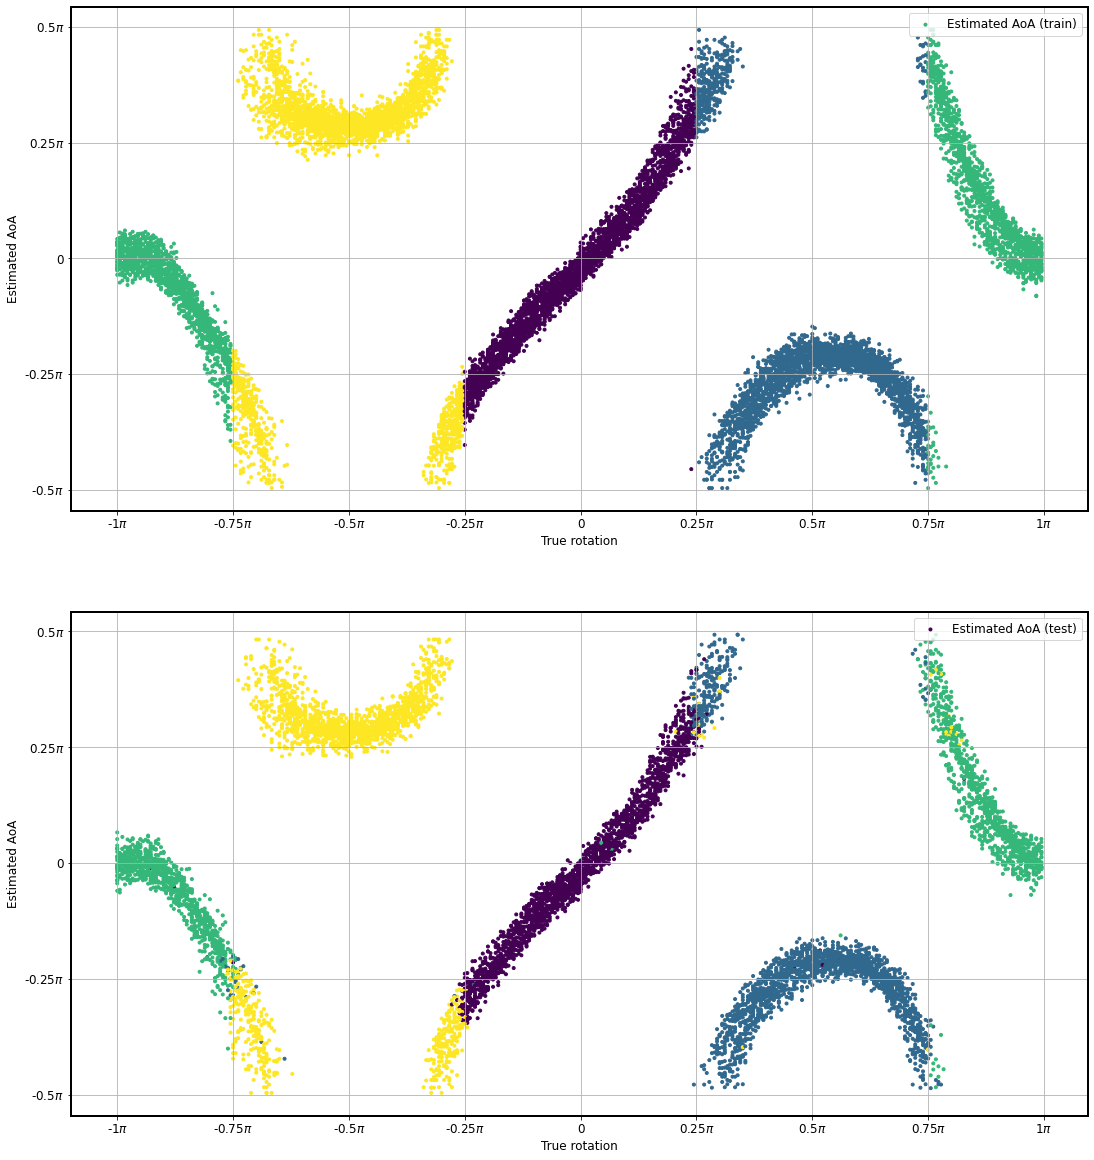

In [91]:
#fig, ax = plt.subplots(figsize=(15, 10))
#fig, ax = plt.subplots(figsize=(30, 20))
fig, ax = plt.subplots(2, 1, figsize=(30, 20))

def format_plot(ax):
    axis_pi_formatter(ax.yaxis)
    axis_pi_formatter(ax.xaxis)
    ax.grid()
    ax.legend(loc='upper right')
    ax.set_aspect(1)
    ax.set_xlabel('True rotation')
    ax.set_ylabel('Estimated AoA')

ax[0].scatter(meta_train.rotation_rad, meta_train.theta, c=y_pred_train_cl, marker='.', label='Estimated AoA (train)')
format_plot(ax[0])
ax[1].scatter(meta_test.rotation_rad, meta_test.theta, c=y_pred_test_cl, marker='.', label='Estimated AoA (test)')
format_plot(ax[1])

save_plot('mlp_90deg_clf_prediction')
plt.show()

In [92]:
accuracy_score(y_train_cl, y_pred_train_cl), accuracy_score(y_test_cl, y_pred_test_cl)

(1.0, 0.9737314197847258)

In [93]:
precision_score(y_train_cl, y_pred_train_cl, average=None), recall_score(y_train_cl, y_pred_train_cl, average=None), precision_score(y_train_cl, y_pred_train_cl, average='micro'), recall_score(y_train_cl, y_pred_train_cl, average='micro')

(array([1., 1., 1., 1.]), array([1., 1., 1., 1.]), 1.0, 1.0)

In [94]:
precision_score(y_test_cl, y_pred_test_cl, average=None), recall_score(y_test_cl, y_pred_test_cl, average=None), precision_score(y_test_cl, y_pred_test_cl, average='micro'), recall_score(y_test_cl, y_pred_test_cl, average='micro')

(array([0.97774406, 0.96476427, 0.9829606 , 0.97001034]),
 array([0.97873418, 0.97590361, 0.96396867, 0.9760666 ]),
 0.9737314197847258,
 0.9737314197847258)